In [7]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random
import glob
import pickle
import six
import tensorflow as tf

from edward.models import (
    Dirichlet, Categorical, Empirical, ParamMixture)

plt.style.use('ggplot')

In [2]:
def load_mimic_data(data_dir):
    """Loads a dataset extracted from the MIMIC-III critical care database.
    
    Args:
        None
        
    Returns:
        w - List of lists of 1D NumPy arrays containing
            tokens for each individual and data source.
        dicts - List of token id to token dictionaries for 
                all data types
    """
    
    data_types = ['note', 'lab', 'med']

    D = 10  # number of patients    
    S = len(glob.glob(os.path.join(data_dir, 'corpora/*.txt')))

    dicts = [None] * S
    w = [[None] * S for d in range(D)]
    z = [[None] * S for d in range(D)]
    for s, dt in enumerate(data_types):
        dict_file = os.path.join(data_dir,
                                 'dicts',
                                 dt + '_dict.p')

        form_corpus_file = os.path.join(data_dir, 
                                        'form_corpora',
                                        dt + '_form_corpus.txt')
        
        with open(dict_file, 'rb') as file:
            dicts[s] = pickle.load(file)
            

        with open(form_corpus_file, 'r') as file:
            for d, line in enumerate(file):
                doc_tokenids = []
                tokenid_counts = line.split(' ')[1:]

                for tic in tokenid_counts:
                    ti_c = tic.strip().split(':')
                    tokenid = float(ti_c[0])
                    count = int(ti_c[1])
                    
                    if count == 1:
                        count += 1

                    for _ in range(count):
                        doc_tokenids.append(tokenid)

                w[d][s] = np.array(doc_tokenids)
    
    return w, dicts, D, S



In [5]:
###############
# DATA
###############

# Get MIMIC data
w_train, dicts, D, S = load_mimic_data('../data')

# Calculate vocabulary size for each data type
V = [None] * S
for s in range(S):
    V[s] = len(dicts[s])
    

In [6]:
###############
# MODEL
###############
K = 5

alpha = tf.ones(K) * 0.01

beta, phi = [None] * S, [None] * S
for s in range(S):
    beta[s] = tf.ones(V[s]) * 0.01
    phi[s] = Dirichlet(concentration=beta[s], 
                       sample_shape=K)

theta = [None] * D
w = [[None] * S for d in range(D)]
z = [[None] * S for d in range(D)]
for d in range(D):
    theta[d] = Dirichlet(concentration=alpha)
    
    for s in range(S):

        w[d][s] = ParamMixture(mixing_weights=theta[d], 
                               component_params={'probs': phi[s]},
                               component_dist=Categorical,
                               sample_shape=len(w_train[d][s]),
                               validate_args=True)

        z[d][s] = w[d][s].cat
        

In [8]:
####################
#INFERENCE
####################


total_time = time.time() # track total time cost

# Data vars
data_dict = {}
for d in range(D):
    for s in range(S):
        data_dict[w[d][s]] = w_train[d][s]


# Latent vars
latent_vars_dict = {}

T = 2000 # number of samples
qphi = [None] * S
for s in range(S):
    qphi[s] = Empirical(tf.Variable(tf.zeros([T, K, V[s]])))
    latent_vars_dict[phi[s]] = qphi[s]

qtheta = [None] * D
qz = [[None] * S for d in range(D)]
for d in range(D):
    qtheta[d]= Empirical(tf.Variable(tf.ones([T, K]) / K))
    latent_vars_dict[theta[d]] = qtheta[d]
    
    for s in range(S):
        N = len(w_train[d][s])

        qz[d][s] = Empirical(tf.Variable(tf.zeros([T, N], dtype=tf.int32)))
        latent_vars_dict[z[d][s]] = qz[d][s]
print()

# Proposal vars
proposal_vars_dict = {}

phi_cond = [None] * S
for s in range(S):
    it_time = time.time()
    
    print('Building proposals for phi: {} of {}'.format(s + 1, S))
    phi_cond[s] = ed.complete_conditional(phi[s])
    proposal_vars_dict[phi[s]] = phi_cond[s]
    
    end = time.time()
    print('Total time: {:.2f}s, Iteration time: {:.2f}s\n'.format(end - tot_time,
                                                                  end - it_time))

          
theta_cond = [None] * D
z_cond = [[None] * S for d in range(D)]
for d in range(D):
    it_time = time.time()
    print('Building proposals for theta, z: {} of {}'.format(d + 1, D))
          
    theta_cond[d] = ed.complete_conditional(theta[d])
    proposal_vars_dict[theta[d]] = theta_cond[d]
    
    for s in range(S):
        z_cond[d][s] = ed.complete_conditional(z[d][s])
        proposal_vars_dict[z[d][s]] = z_cond[d][s]
        
    end = time.time()
    print('Total time: {:.2f}s, Iteration time: {:.2f}s\n'.format(end - tot_time,
                                                                  end - it_time))



Building latents for phi 1 of 3
Building latents for phi 2 of 3
Building latents for phi 3 of 3
Building latents for doc 1 of 10
Building latents for doc 2 of 10
Building latents for doc 3 of 10
Building latents for doc 4 of 10
Building latents for doc 5 of 10
Building latents for doc 6 of 10
Building latents for doc 7 of 10
Building latents for doc 8 of 10
Building latents for doc 9 of 10
Building latents for doc 10 of 10

Building proposals for phi 1 of 3
Overall time: 6.24, Iteration time: 3.20
Building proposals for phi 2 of 3
Overall time: 9.50, Iteration time: 3.26
Building proposals for phi 3 of 3
Overall time: 12.57, Iteration time: 3.07
Building proposals for doc 1 of 10
Overall time: 21.55, Iteration time: 8.98
Building proposals for doc 2 of 10
Overall time: 33.14, Iteration time: 11.59
Building proposals for doc 3 of 10
Overall time: 44.84, Iteration time: 11.70
Building proposals for doc 4 of 10
Overall time: 56.59, Iteration time: 11.75
Building proposals for doc 5 of 10


In [9]:
# Inference procedure w/Gibbs sampling
inference = ed.Gibbs(latent_vars=latent_vars_dict,
                     proposal_vars=proposal_vars_dict,
                     data=data_dict)

inference.initialize(n_iter=T, n_print=10, logdir='log')

tf.global_variables_initializer().run()

for n in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    
inference.finalize()

2000/2000 [100%] ██████████████████████████████ Elapsed: 972s | Acceptance Rate: 1.000


In [10]:
from wordcloud import WordCloud

def gen_wordcloud(tokens, probs):

    def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return "hsl(0, 100%%, %d%%)" % random.randint(25, 55)

    def green_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return "hsl(90, 100%%, %d%%)" % random.randint(27, 37)

    def blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return "hsl(200, 100%%, %d%%)" % random.randint(30, 60)


    colors = {0 : red_color_func, 
              1 : green_color_func,
              2 : blue_color_func}

    f, axn = plt.subplots(1, 3)

    for j, ax in enumerate(axn.flatten()):

        tokens_probs = dict((t, p) for t, p in zip(tokens[j], probs[j]))

        wordcloud = WordCloud(background_color="white", relative_scaling=0.5)
        wordcloud.generate_from_frequencies(tokens_probs)
        wordcloud.recolor(color_func=colors[j], random_state=3)

        ax.axis('off')
        ax.imshow(wordcloud)        
        ax.set_title(data_types[j], fontsize=50)

        #plt.savefig('../figures/wcloud_phen{}.pdf'.format(phen_num), dpi=1000, format='pdf', pad_inches=0)
    f = plt.gcf()
    f.set_figwidth(36.0)
    f.set_figheight(36.0)
    
    plt.tight_layout()
    plt.show()
    plt.close('all')

In [11]:
qphi_sample = [None] * S
for s in range(S):
    qphi_sample[s] = qphi[s].params[-1].eval()
    
probs = [[None] * S for k in range(K)]
for k in range(K):
    for s in range(S):
        probs[k][s] = qphi_sample[s][k, :]
        
tokens = [[None] * V[s] for s in range(S)]
for s in range(S):
    for i, tok in enumerate(dicts[s].values()):
        tokens[s][i] = tok
        

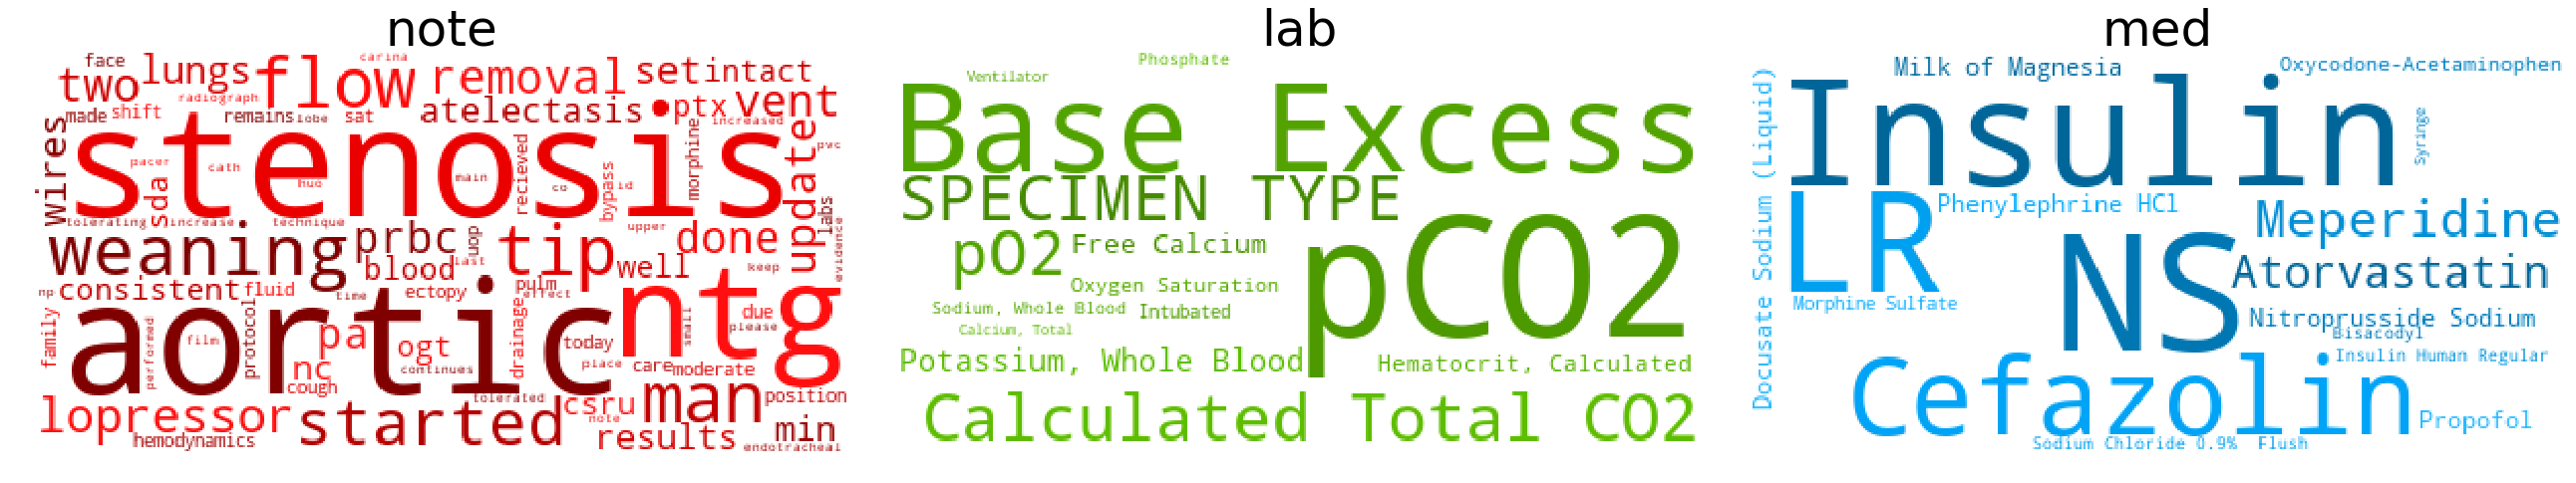

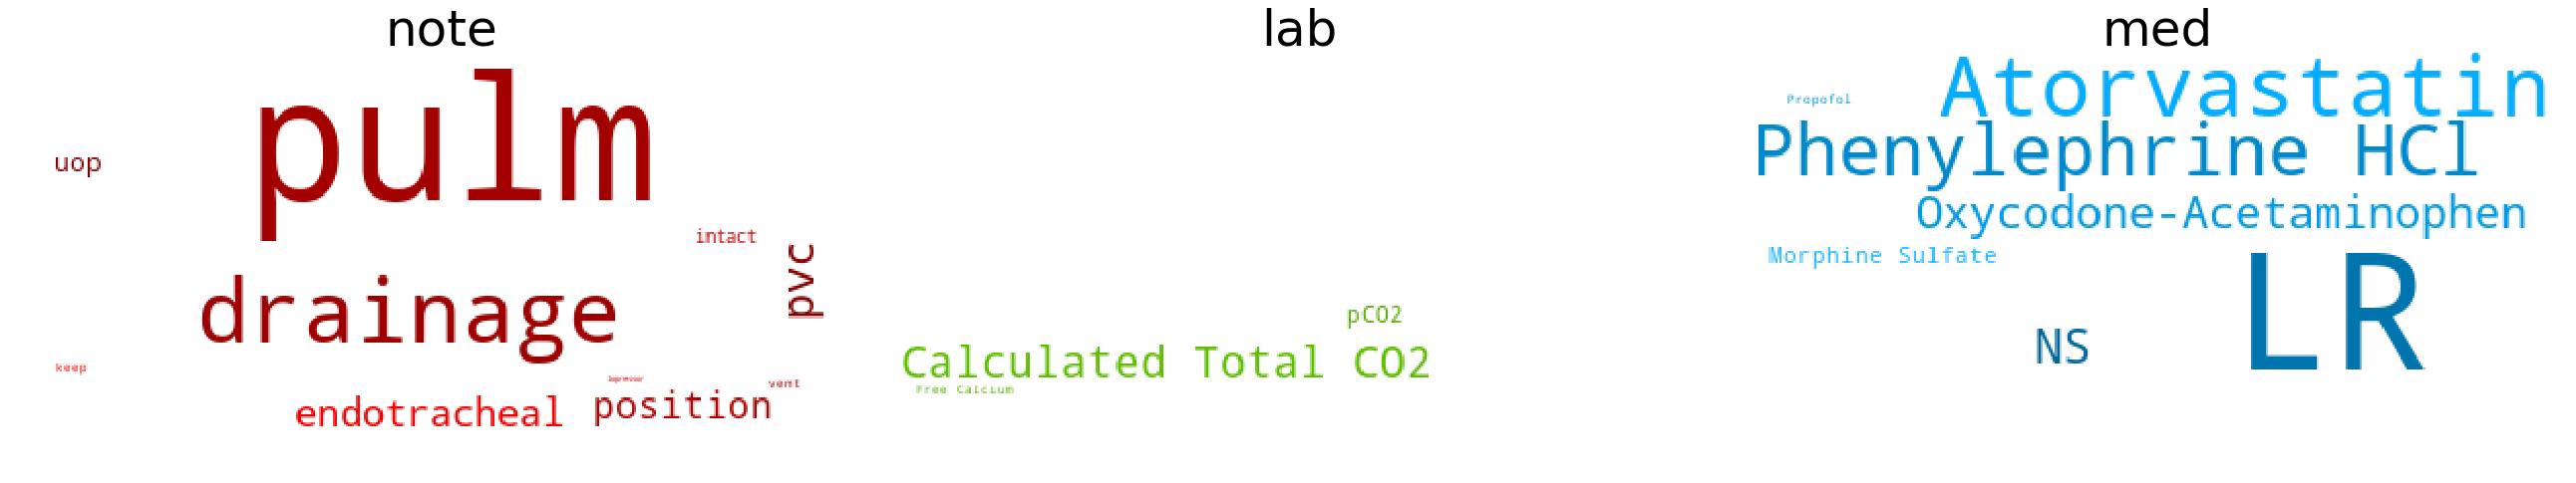

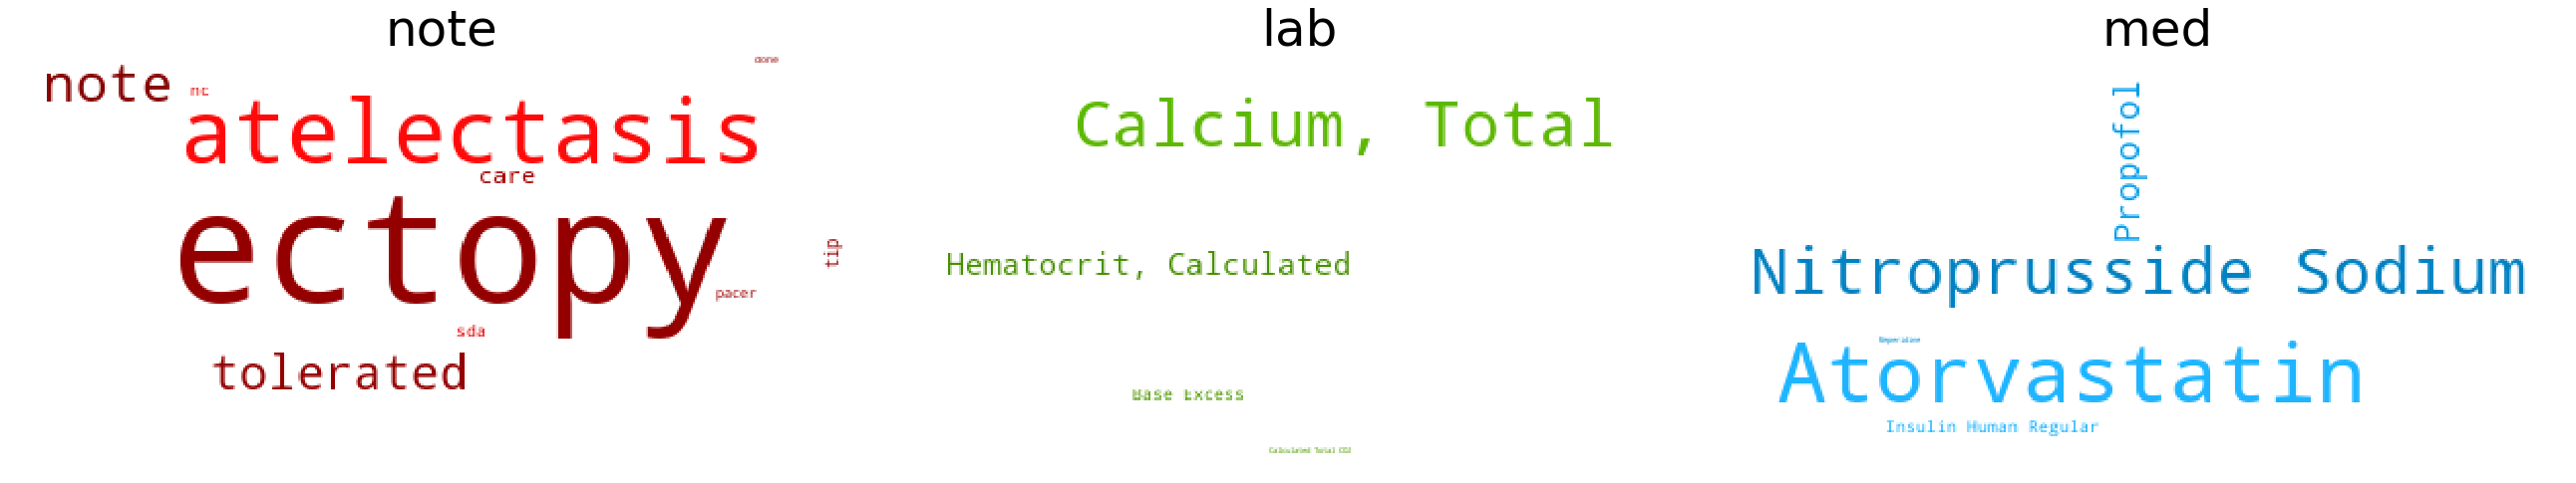

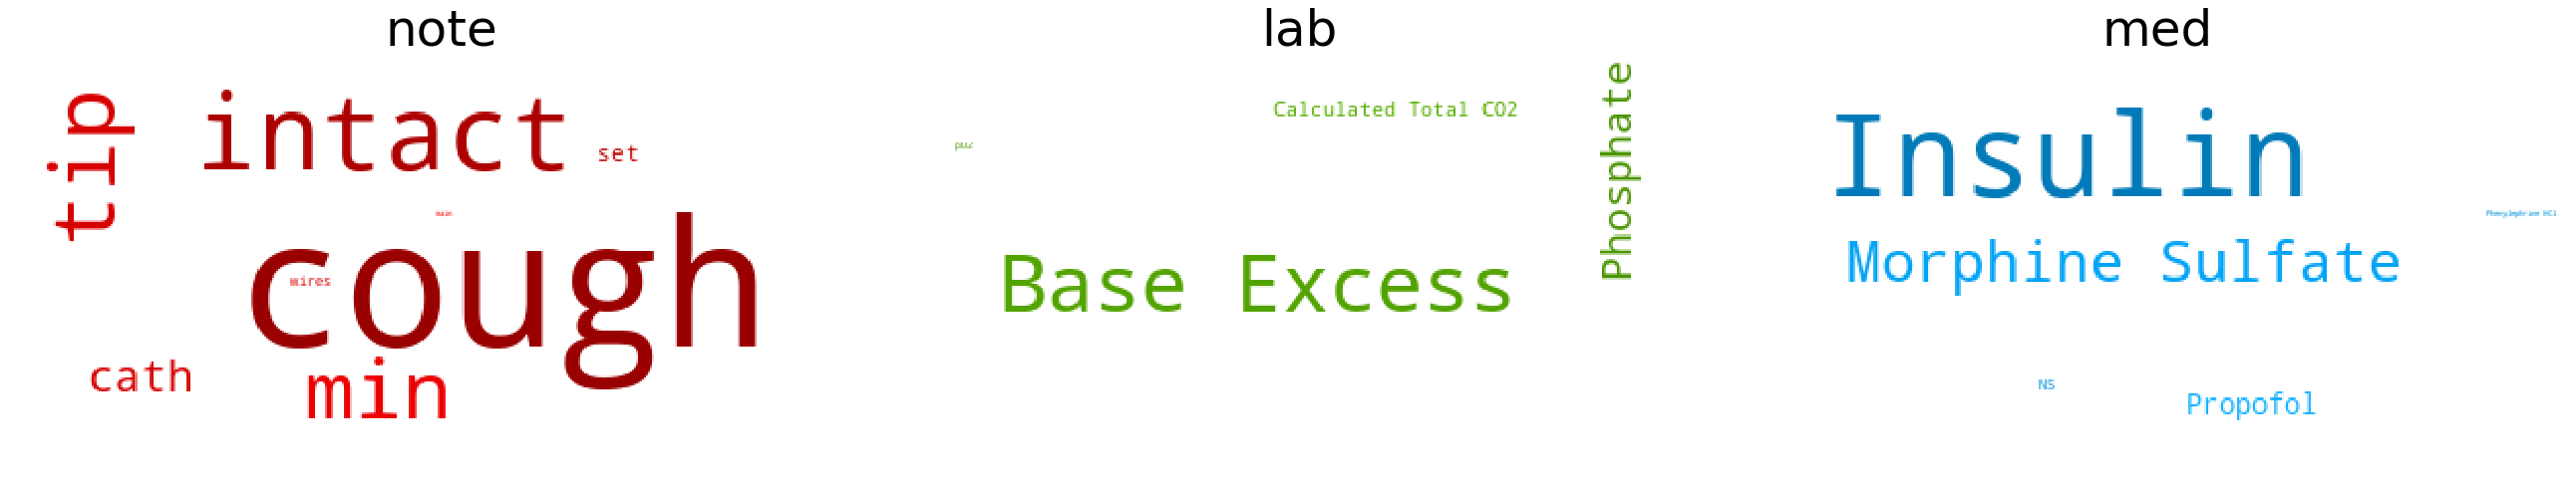

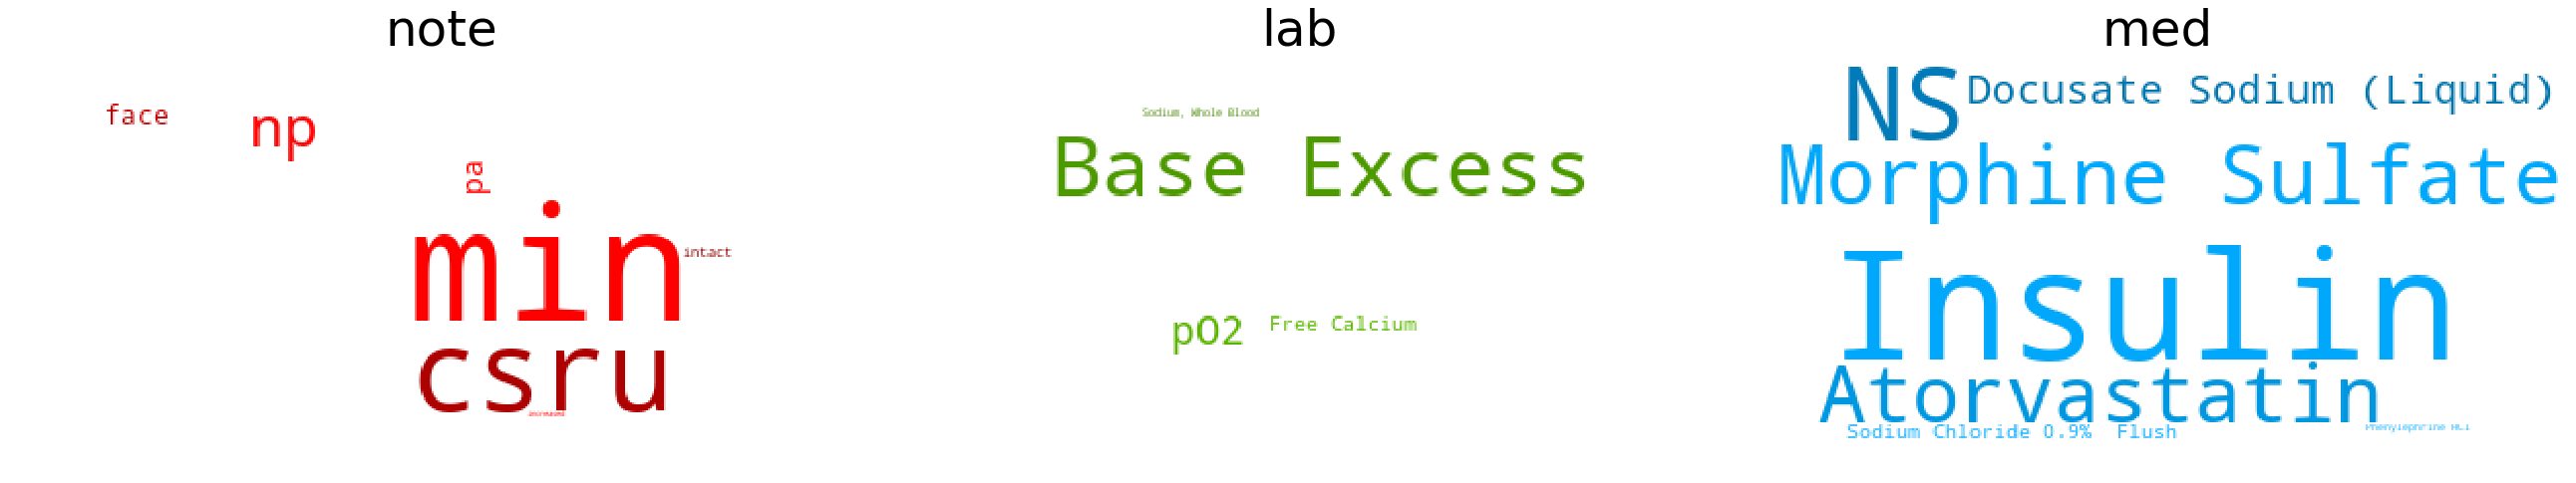

In [12]:
for k in range(K):
    gen_wordcloud(tokens, probs[k])

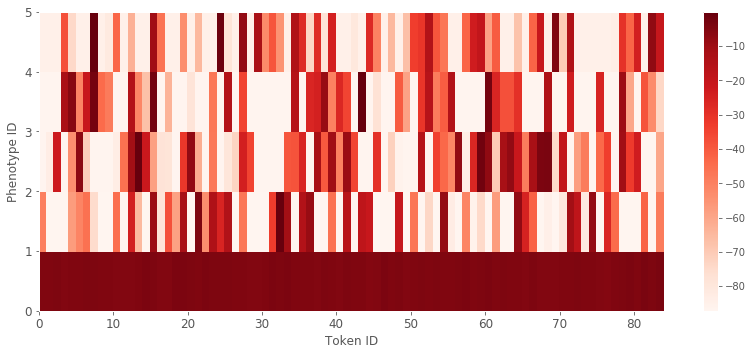

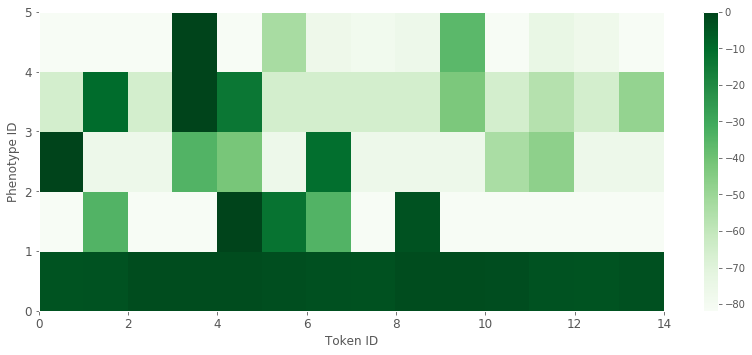

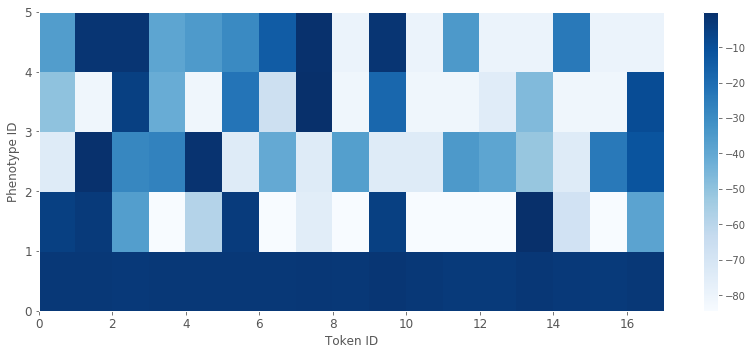

In [34]:
colormaps = ['Reds', 'Greens', 'Blues']
for s in range(S):
    plt.pcolormesh(np.log(qphi[s].params[-1].eval()), cmap=colormaps[s])
    plt.tick_params(labelsize='large')
    plt.xlabel('Token ID')
    plt.ylabel('Phenotype ID')
    plt.colorbar()
    
    
    f = plt.gcf()
    f.set_figwidth(14.0)
    f.set_figheight(5.5)
    
    plt.show()
